# <b> Building a Deep Learning Cat and Dog classifier 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading Libraries

In [2]:
import os
import random
import shutil
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras as keras
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2, InceptionV3, Xception
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D


import warnings
warnings.filterwarnings("ignore")

## Loading Data

In [3]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
# Unzipping the data and loading it to Colab
!unzip -q "/content/drive/MyDrive/code_files/cats_dogs/CatsDogs.zip"

## Data Preprocessing

In [5]:
# Converting the data into the required format and leaving out the unidentified images and raising an exception message for the same
dataset_dir = 'CatsDogs'

# Create a new directory for storing the converted images
converted_dir = os.path.join(dataset_dir, 'Converted')
os.makedirs(converted_dir, exist_ok=True)

# Convert images to JPG format
for class_name in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, class_name)
    converted_class_dir = os.path.join(converted_dir, class_name)
    os.makedirs(converted_class_dir, exist_ok=True)
    
    for filename in os.listdir(class_dir):
        img_path = os.path.join(class_dir, filename)
        converted_img_path = os.path.join(converted_class_dir, filename)
        
        try:
            img = Image.open(img_path)
            img = img.convert('RGB')  # Convert to RGB format
            img.save(converted_img_path, 'JPEG')
        except Exception as e:
            print(f"Error converting image {img_path}: {str(e)}")


Error converting image CatsDogs/Dogs/11702.jpg: cannot identify image file 'CatsDogs/Dogs/11702.jpg'
Error converting image CatsDogs/Converted/Dogs: [Errno 21] Is a directory: 'CatsDogs/Converted/Dogs'
Error converting image CatsDogs/Converted/Converted: [Errno 21] Is a directory: 'CatsDogs/Converted/Converted'
Error converting image CatsDogs/Cats/666.jpg: cannot identify image file 'CatsDogs/Cats/666.jpg'


- Here we have converted all the images into RGB format which were previosuly not present and from analysis, we even find that there are some corrupted images which needs to be removed before further usage so we have created a new folder named converted to store all the images that are converted.

In [6]:
# Path of the folder to be removed
folder_path = '/content/CatsDogs/Converted/Converted'
# Removing the folder
shutil.rmtree(folder_path)

In [7]:
# Define the image size and batch size
image_size = (150, 150)
batch_size = 32


# Set the path to the dataset folder
data_dir = '/content/CatsDogs/Converted'
# Perform train-test split
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [8]:
# Loading the data from the folders using datagen
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    color_mode='grayscale',  # Convert images to grayscale
    seed=42
)

# Loading the data from the folders using datagen
test_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    color_mode='grayscale',  # Convert images to grayscale
    seed=42
)


Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


### EDA

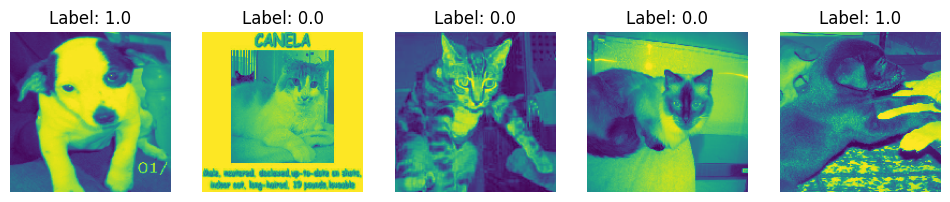

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot images from train_generator
def plot_images(generator, num_images=5):
    # Get a batch of images and labels from the generator
    images, labels = next(generator)

    # Plot the images
    fig, axes = plt.subplots(1, num_images, figsize=(12, 12))
    for i in range(num_images):
        axes[i].imshow(images[i])
        axes[i].axis('off')
        axes[i].set_title('Label: {}'.format(labels[i]))

    plt.show()

# Plot images from train_generator
plot_images(train_generator)


- The images seem to be in highlighted color due to the plotting structure of matplotlib and the converted image structure of RGB.

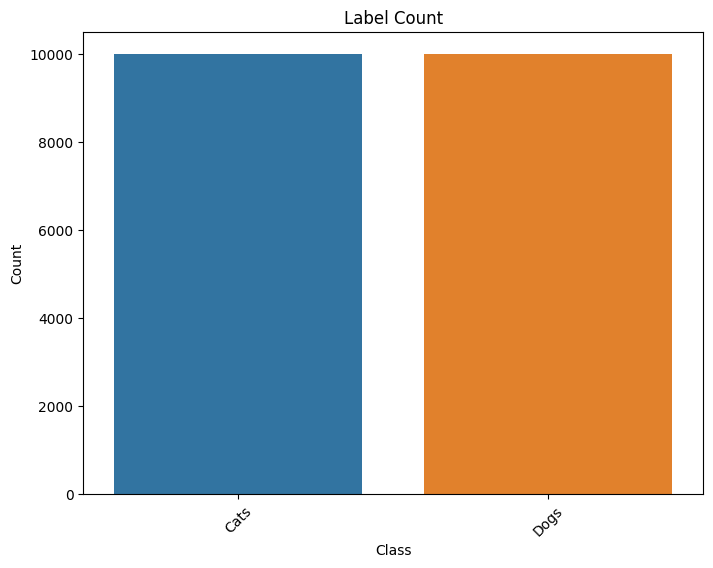

In [10]:

# Create a countplot of labels
def countplot_labels(generator):
    # Get all the labels from the generator
    labels = generator.classes

    # Convert the numeric labels to class names
    class_names = list(generator.class_indices.keys())
    label_names = [class_names[label] for label in labels]

    # Plot the countplot
    plt.figure(figsize=(8, 6))
    sns.countplot(x=label_names)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Label Count')
    plt.xticks(rotation=45)

    plt.show()

# Create a countplot of labels
countplot_labels(train_generator)


- The dataset is well-balanced so there is no issue of imbalance here.

## Building Models

### Model-1(custom-cnn1)

In [37]:

# Define the CNN model architecture
model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()

Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 34, 34, 128)       73856     
                                   

In [38]:

# Train the model
history1 = model1.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

Epoch 1/10
625/625 [==============================] - 151s 239ms/step - loss: 0.6380 - accuracy: 0.6231 - val_loss: 0.5434 - val_accuracy: 0.7194
Epoch 2/10
625/625 [==============================] - 83s 132ms/step - loss: 0.4812 - accuracy: 0.7696 - val_loss: 0.4972 - val_accuracy: 0.7722
Epoch 3/10
625/625 [==============================] - 84s 134ms/step - loss: 0.3965 - accuracy: 0.8194 - val_loss: 0.3686 - val_accuracy: 0.8303
Epoch 4/10
625/625 [==============================] - 89s 142ms/step - loss: 0.3323 - accuracy: 0.8554 - val_loss: 0.3903 - val_accuracy: 0.8241
Epoch 5/10
625/625 [==============================] - 85s 136ms/step - loss: 0.2790 - accuracy: 0.8811 - val_loss: 0.3403 - val_accuracy: 0.8546
Epoch 6/10
625/625 [==============================] - 88s 141ms/step - loss: 0.2277 - accuracy: 0.9054 - val_loss: 0.3061 - val_accuracy: 0.8720
Epoch 7/10
625/625 [==============================] - 89s 142ms/step - loss: 0.1751 - accuracy: 0.9291 - val_loss: 0.3371 - val_a

In [39]:
# Evaluate the model
test_loss, test_accuracy = model1.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

157/157 [==============================] - 16s 101ms/step - loss: 0.4870 - accuracy: 0.8613
Test loss: 0.487032949924469
Test accuracy: 0.8613445162773132


In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Generate predictions on the test data
y_pred = model1.predict(test_generator)
y_pred = np.round(y_pred).flatten()

# Get the true labels from the test data
y_true = test_generator.classes

# Compute classification metrics
report = classification_report(y_true, y_pred, target_names=['cat', 'dog'])
print(report)


157/157 [==============================] - 48s 121ms/step
              precision    recall  f1-score   support

         cat       0.49      0.50      0.50      2499
         dog       0.49      0.49      0.49      2499

    accuracy                           0.49      4998
   macro avg       0.49      0.49      0.49      4998
weighted avg       0.49      0.49      0.49      4998



157/157 [==============================] - 25s 160ms/step


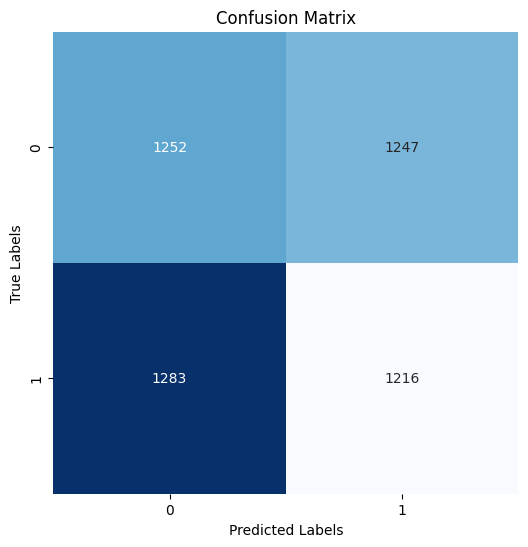

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate predictions on the test data
y_pred = model1.predict(test_generator)
y_pred = np.round(y_pred).flatten()

# Get the true labels from the test data
y_true = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


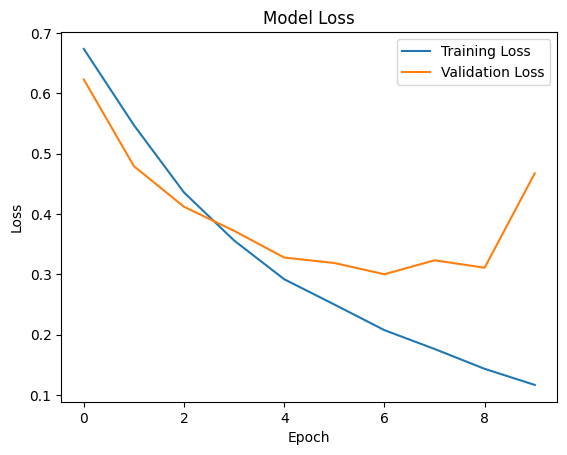

In [ ]:

# Plot the training and validation loss
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()


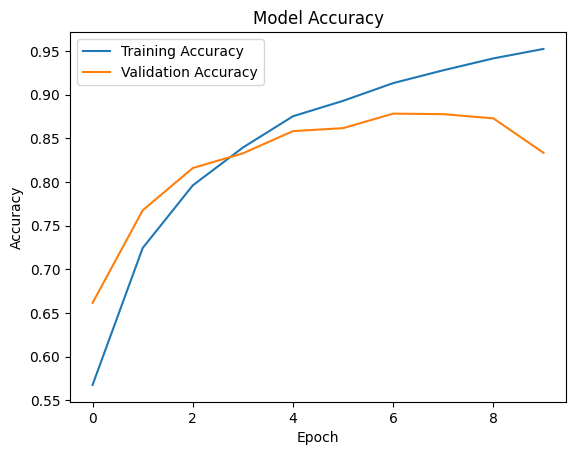

In [ ]:

# Plot the training and validation accuracy
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()


### Model-2(custom-cnn2)

In [42]:

# Define the CNN model architecture
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 17, 17, 64)      

In [43]:

# Train the model
history2 = model2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)



Epoch 1/10
625/625 [==============================] - 92s 143ms/step - loss: 0.6739 - accuracy: 0.5677 - val_loss: 0.6233 - val_accuracy: 0.6617
Epoch 2/10
625/625 [==============================] - 86s 138ms/step - loss: 0.5474 - accuracy: 0.7245 - val_loss: 0.4794 - val_accuracy: 0.7676
Epoch 3/10
625/625 [==============================] - 85s 136ms/step - loss: 0.4358 - accuracy: 0.7962 - val_loss: 0.4121 - val_accuracy: 0.8161
Epoch 4/10
625/625 [==============================] - 90s 144ms/step - loss: 0.3562 - accuracy: 0.8396 - val_loss: 0.3722 - val_accuracy: 0.8329
Epoch 5/10
625/625 [==============================] - 89s 143ms/step - loss: 0.2919 - accuracy: 0.8754 - val_loss: 0.3279 - val_accuracy: 0.8584
Epoch 6/10
625/625 [==============================] - 90s 145ms/step - loss: 0.2500 - accuracy: 0.8931 - val_loss: 0.3189 - val_accuracy: 0.8618
Epoch 7/10
625/625 [==============================] - 82s 132ms/step - loss: 0.2075 - accuracy: 0.9133 - val_loss: 0.3002 - val_ac

In [44]:
# Evaluate the model
test_loss, test_accuracy = model2.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

157/157 [==============================] - 16s 99ms/step - loss: 0.4672 - accuracy: 0.8335
Test loss: 0.467164009809494
Test accuracy: 0.8335334062576294


In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Generate predictions on the test data
y_pred = model2.predict(test_generator)
y_pred = np.round(y_pred).flatten()

# Get the true labels from the test data
y_true = test_generator.classes

# Compute classification metrics
report = classification_report(y_true, y_pred, target_names=['cat', 'dog'])
print(report)


157/157 [==============================] - 48s 121ms/step
              precision    recall  f1-score   support

         cat       0.49      0.50      0.50      2499
         dog       0.49      0.49      0.49      2499

    accuracy                           0.49      4998
   macro avg       0.49      0.49      0.49      4998
weighted avg       0.49      0.49      0.49      4998



157/157 [==============================] - 25s 160ms/step


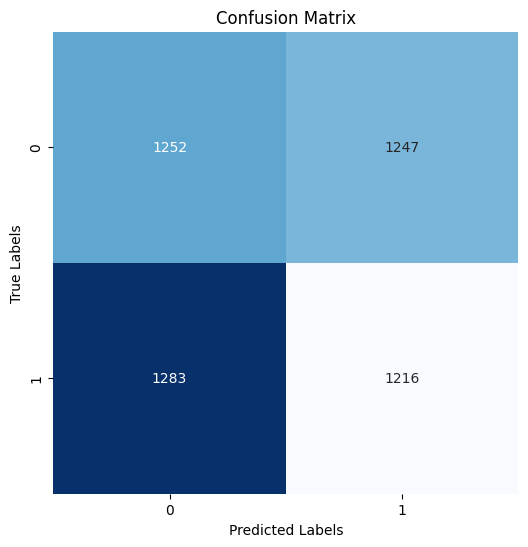

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate predictions on the test data
y_pred = model2.predict(test_generator)
y_pred = np.round(y_pred).flatten()

# Get the true labels from the test data
y_true = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


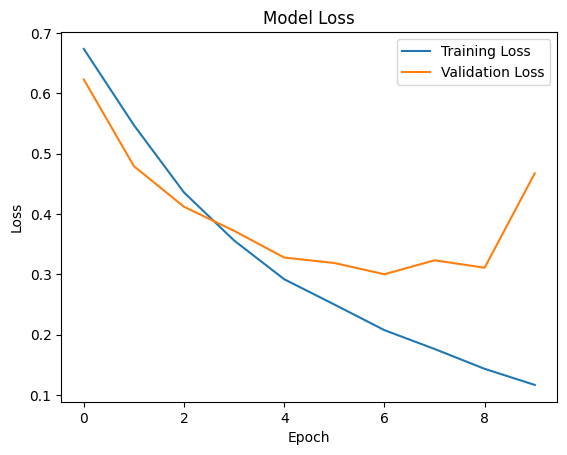

In [ ]:

# Plot the training and validation loss
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()


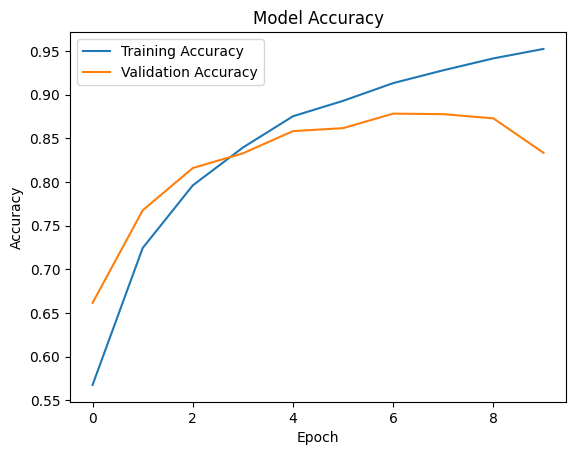

In [ ]:

# Plot the training and validation accuracy
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()


### Model-3(custom-cnn3)

In [80]:

# Define the custom architecture CNN model
model3 = Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model3.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model3.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_136 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_137 (Conv2D)         (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_138 (Conv2D)         (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 17, 17, 128)    

In [81]:
# Train the custom architecture model
history3 = model3.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=5,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)


Epoch 1/5
625/625 [==============================] - 113s 177ms/step - loss: 0.6179 - accuracy: 0.6413 - val_loss: 0.5217 - val_accuracy: 0.7398
Epoch 2/5
625/625 [==============================] - 91s 146ms/step - loss: 0.4939 - accuracy: 0.7600 - val_loss: 0.4715 - val_accuracy: 0.7871
Epoch 3/5
625/625 [==============================] - 91s 146ms/step - loss: 0.4359 - accuracy: 0.7962 - val_loss: 0.4280 - val_accuracy: 0.8035
Epoch 4/5
625/625 [==============================] - 87s 140ms/step - loss: 0.3920 - accuracy: 0.8243 - val_loss: 0.4048 - val_accuracy: 0.8203
Epoch 5/5
625/625 [==============================] - 90s 144ms/step - loss: 0.3611 - accuracy: 0.8408 - val_loss: 0.3768 - val_accuracy: 0.8287


In [82]:
test_loss3, test_accuracy3 = model3.evaluate(test_generator)
print('Model 3 - Test loss:', test_loss3)
print('Model 3 - Test accuracy:', test_accuracy3)

157/157 [==============================] - 16s 103ms/step - loss: 0.3767 - accuracy: 0.8289
Model 3 - Test loss: 0.376730352640152
Model 3 - Test accuracy: 0.8289315700531006


In [83]:
import numpy as np
from sklearn.metrics import classification_report

# Generate predictions on the test data
y_pred = model3.predict(test_generator)
y_pred = np.round(y_pred).flatten()

# Get the true labels from the test data
y_true = test_generator.classes

# Compute classification metrics
report = classification_report(y_true, y_pred, target_names=['cat', 'dog'])
print(report)


157/157 [==============================] - 16s 100ms/step
              precision    recall  f1-score   support

         cat       0.50      0.46      0.48      2499
         dog       0.50      0.55      0.52      2499

    accuracy                           0.50      4998
   macro avg       0.50      0.50      0.50      4998
weighted avg       0.50      0.50      0.50      4998



157/157 [==============================] - 16s 100ms/step


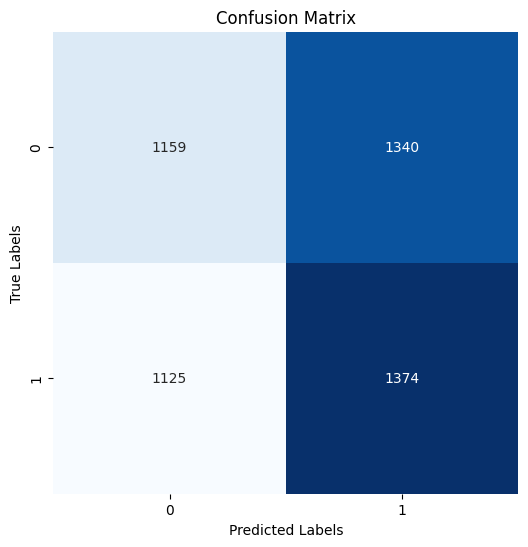

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate predictions on the test data
y_pred = model3.predict(test_generator)
y_pred = np.round(y_pred).flatten()

# Get the true labels from the test data
y_true = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


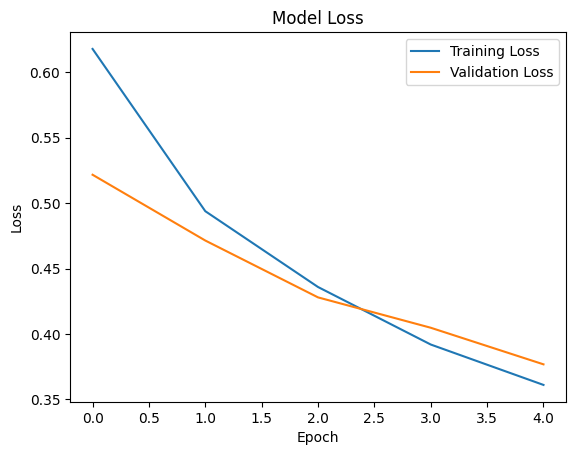

In [85]:

# Plot the training and validation loss
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()


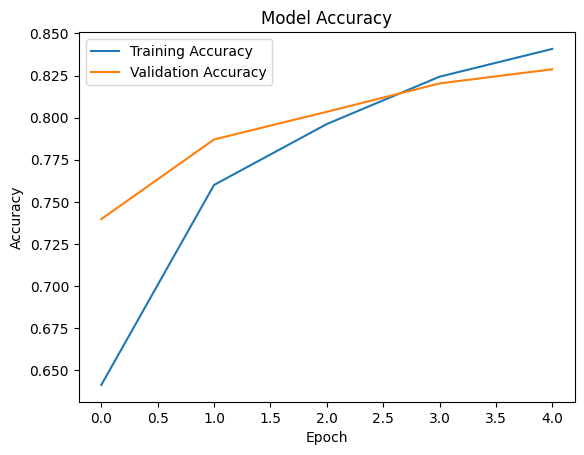

In [86]:

# Plot the training and validation accuracy
plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()


### Model-4(custom-neural network)

In [9]:

# Define the neural network model
model = Sequential([
    Flatten(input_shape=(150, 150, 1)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 22500)             0         
                                                                 
 dense (Dense)               (None, 128)               2880128   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,888,449
Trainable params: 2,888,449
Non-trainable params: 0
_________________________________________________________________


In [10]:

# Train the neural network model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=5,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)



Epoch 1/5
625/625 [==============================] - 96s 143ms/step - loss: 0.6950 - accuracy: 0.5497 - val_loss: 0.6661 - val_accuracy: 0.5849
Epoch 2/5
625/625 [==============================] - 81s 130ms/step - loss: 0.6702 - accuracy: 0.5885 - val_loss: 0.6657 - val_accuracy: 0.6012
Epoch 3/5
625/625 [==============================] - 79s 127ms/step - loss: 0.6634 - accuracy: 0.5964 - val_loss: 0.6612 - val_accuracy: 0.5992
Epoch 4/5
625/625 [==============================] - 83s 132ms/step - loss: 0.6561 - accuracy: 0.6079 - val_loss: 0.7141 - val_accuracy: 0.5461
Epoch 5/5
625/625 [==============================] - 82s 131ms/step - loss: 0.6543 - accuracy: 0.6111 - val_loss: 0.6582 - val_accuracy: 0.6004


In [11]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

157/157 [==============================] - 17s 108ms/step - loss: 0.6581 - accuracy: 0.6006
Test loss: 0.6580702662467957
Test accuracy: 0.6006402373313904


In [12]:
import numpy as np
from sklearn.metrics import classification_report

# Generate predictions on the test data
y_pred = model.predict(test_generator)
y_pred = np.round(y_pred).flatten()

# Get the true labels from the test data
y_true = test_generator.classes

# Compute classification metrics
report = classification_report(y_true, y_pred, target_names=['cat', 'dog'])
print(report)


157/157 [==============================] - 15s 95ms/step
              precision    recall  f1-score   support

         cat       0.49      0.44      0.47      2499
         dog       0.50      0.55      0.52      2499

    accuracy                           0.50      4998
   macro avg       0.50      0.50      0.49      4998
weighted avg       0.50      0.50      0.49      4998



157/157 [==============================] - 15s 94ms/step


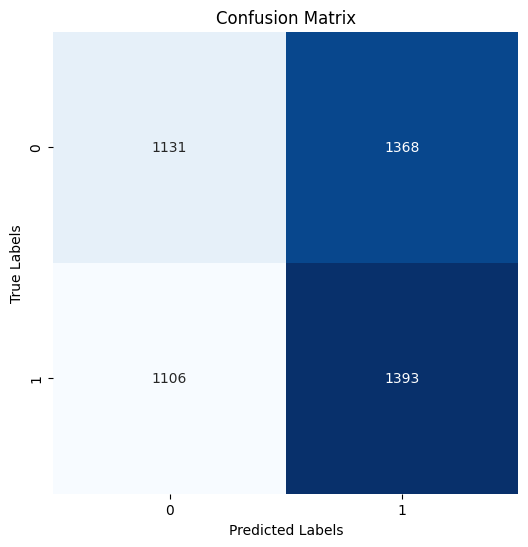

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate predictions on the test data
y_pred = model.predict(test_generator)
y_pred = np.round(y_pred).flatten()

# Get the true labels from the test data
y_true = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


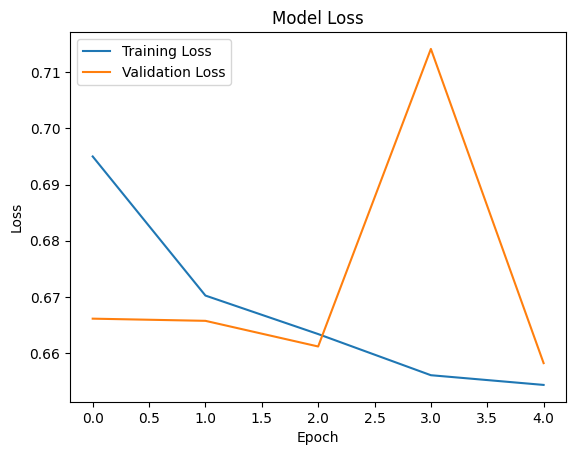

In [14]:

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()


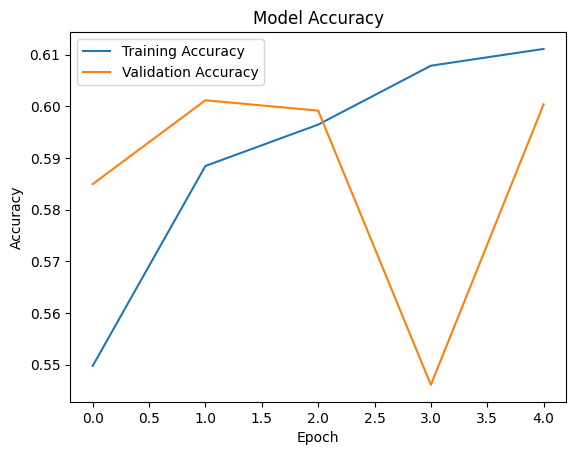

In [15]:

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()


### Model with Cross validation

In [16]:
from sklearn.model_selection import StratifiedKFold
# Get the image data and labels
images = train_generator[0][0]
labels = train_generator[0][1]
num_folds = 5

# Create Stratified K-fold cross-validator
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

fold_losses = []
fold_accuracies = []

# Perform K-fold cross-validation
for fold, (train_indices, val_indices) in enumerate(kfold.split(images, labels)):
    print(f"Fold: {fold+1}")
    train_images, val_images = images[train_indices], images[val_indices]
    train_labels, val_labels = labels[train_indices], labels[val_indices]

    # Define the neural network model
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(150, 150, 1)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    # Train the model
    history = model.fit(train_images, train_labels, batch_size=batch_size, epochs=10)

    # Evaluate the model on validation data
    val_loss, val_accuracy = model.evaluate(val_images, val_labels)
    fold_losses.append(val_loss)
    fold_accuracies.append(val_accuracy)



Fold: 1
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 22500)             0         
                                                                 
 dense_3 (Dense)             (None, 128)               2880128   
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,888,449
Trainable params: 2,888,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 0.7073 - accuracy: 0.4800
Epoch 2/10
1/1 [==============================] - 0s 12ms/step - loss: 1.

1/1 [==============================] - 0s 188ms/step - loss: 0.6604 - accuracy: 0.6667
Fold: 5
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 22500)             0         
                                                                 
 dense_15 (Dense)            (None, 128)               2880128   
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2,888,449
Trainable params: 2,888,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 0.8080 - acc

1/1 [==============================] - 0s 136ms/step - loss: 0.6790 - accuracy: 0.6667


In [17]:
# Calculate the average loss and accuracy across all folds
avg_loss = np.mean(fold_losses)
avg_accuracy = np.mean(fold_accuracies)

print('Average Validation Loss:', avg_loss)
print('Average Validation Accuracy:', avg_accuracy)

Average Validation Loss: 0.658057177066803
Average Validation Accuracy: 0.6904762029647827


### Model 5(Vgg16)

In [50]:
# # Set the path to the dataset folder
data_dir = '/content/CatsDogs/Converted'

# # Perform train-test split
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    # color_mode='grayscale',  # Convert images to grayscale
    seed=42
)

test_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    # color_mode='grayscale',  # Convert images to grayscale
    seed=42
)

# Define the first model using VGG16 pre-trained classifier
base_model1 = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
x1 = base_model1.output
x1 = Flatten()(x1)
x1 = Dense(512, activation='relu')(x1)
predictions1 = Dense(1, activation='sigmoid')(x1)
model1 = Model(inputs=base_model1.input, outputs=predictions1)

# Freeze the pre-trained layers
for layer in base_model1.layers:
    layer.trainable = False

# Compile the model
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()



Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                        

In [51]:
# Train the first model
history1 = model1.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=5,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)


Epoch 1/10
625/625 [==============================] - 145s 226ms/step - loss: 0.2865 - accuracy: 0.8824 - val_loss: 0.2519 - val_accuracy: 0.8896
Epoch 2/10
625/625 [==============================] - 98s 157ms/step - loss: 0.1921 - accuracy: 0.9195 - val_loss: 0.2408 - val_accuracy: 0.8962
Epoch 3/10
625/625 [==============================] - 98s 157ms/step - loss: 0.1662 - accuracy: 0.9318 - val_loss: 0.2196 - val_accuracy: 0.9097
Epoch 4/10
625/625 [==============================] - 95s 152ms/step - loss: 0.1370 - accuracy: 0.9424 - val_loss: 0.2766 - val_accuracy: 0.8806
Epoch 5/10
625/625 [==============================] - 93s 149ms/step - loss: 0.1157 - accuracy: 0.9531 - val_loss: 0.2392 - val_accuracy: 0.9151
Epoch 6/10
625/625 [==============================] - 94s 150ms/step - loss: 0.0842 - accuracy: 0.9671 - val_loss: 0.2679 - val_accuracy: 0.9097
Epoch 7/10
625/625 [==============================] - 96s 154ms/step - loss: 0.0625 - accuracy: 0.9763 - val_loss: 0.3095 - val_a

In [52]:
# Evaluate the models
test_loss1, test_accuracy1 = model1.evaluate(test_generator)
print('Model 1 - Test loss:', test_loss1)
print('Model 1 - Test accuracy:', test_accuracy1)


157/157 [==============================] - 20s 127ms/step - loss: 0.3985 - accuracy: 0.9082
Model 1 - Test loss: 0.39849618077278137
Model 1 - Test accuracy: 0.9081632494926453


### Model-6(Resnet50)

In [53]:

# Define the second model using ResNet50 pre-trained classifier
base_model2 = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
x2 = base_model2.output
x2 = Flatten()(x2)
x2 = Dense(512, activation='relu')(x2)
predictions2 = Dense(1, activation='sigmoid')(x2)
model2 = Model(inputs=base_model2.input, outputs=predictions2)

# Freeze the pre-trained layers
for layer in base_model2.layers:
    layer.trainable = False

# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()




94765736/94765736 [==============================] - 5s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalizati

In [54]:
# Train the second model
history2 = model2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=5,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

Epoch 1/10
625/625 [==============================] - 103s 158ms/step - loss: 0.6840 - accuracy: 0.6233 - val_loss: 0.6033 - val_accuracy: 0.6653
Epoch 2/10
625/625 [==============================] - 98s 157ms/step - loss: 0.5979 - accuracy: 0.6751 - val_loss: 0.5686 - val_accuracy: 0.7117
Epoch 3/10
625/625 [==============================] - 103s 165ms/step - loss: 0.5754 - accuracy: 0.6963 - val_loss: 0.5710 - val_accuracy: 0.6969
Epoch 4/10
625/625 [==============================] - 101s 161ms/step - loss: 0.5613 - accuracy: 0.7102 - val_loss: 0.5627 - val_accuracy: 0.7027
Epoch 5/10
625/625 [==============================] - 101s 161ms/step - loss: 0.5458 - accuracy: 0.7200 - val_loss: 0.5406 - val_accuracy: 0.7260
Epoch 6/10
625/625 [==============================] - 96s 153ms/step - loss: 0.5382 - accuracy: 0.7301 - val_loss: 0.5338 - val_accuracy: 0.7380
Epoch 7/10
625/625 [==============================] - 94s 151ms/step - loss: 0.5415 - accuracy: 0.7251 - val_loss: 0.5287 - va

In [55]:
test_loss2, test_accuracy2 = model2.evaluate(test_generator)
print('Model 2 - Test loss:', test_loss2)
print('Model 2 - Test accuracy:', test_accuracy2)

157/157 [==============================] - 18s 117ms/step - loss: 0.5773 - accuracy: 0.7015
Model 2 - Test loss: 0.5773480534553528
Model 2 - Test accuracy: 0.7014805674552917


In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Generate predictions on the test data
y_pred = model2.predict(test_generator)
y_pred = np.round(y_pred).flatten()

# Get the true labels from the test data
y_true = test_generator.classes

# Compute classification metrics
report = classification_report(y_true, y_pred, target_names=['cat', 'dog'])
print(report)


157/157 [==============================] - 48s 121ms/step
              precision    recall  f1-score   support

         cat       0.49      0.50      0.50      2499
         dog       0.49      0.49      0.49      2499

    accuracy                           0.49      4998
   macro avg       0.49      0.49      0.49      4998
weighted avg       0.49      0.49      0.49      4998



157/157 [==============================] - 25s 160ms/step


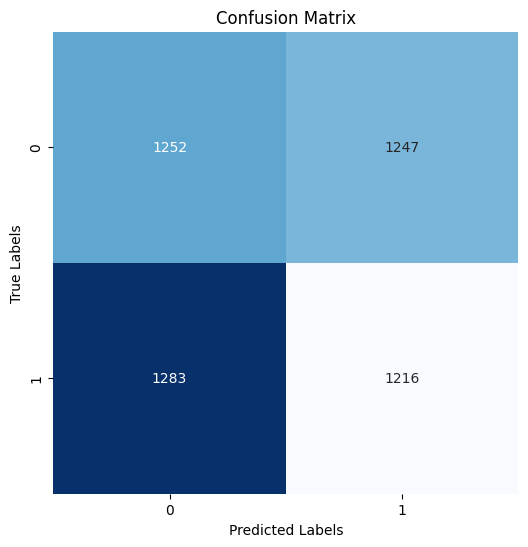

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate predictions on the test data
y_pred = model2.predict(test_generator)
y_pred = np.round(y_pred).flatten()

# Get the true labels from the test data
y_true = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


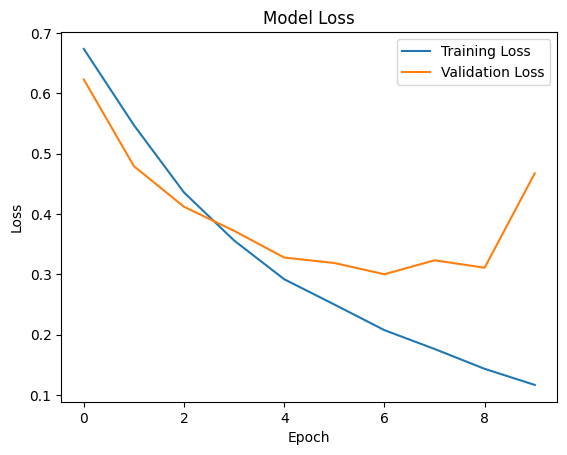

In [ ]:

# Plot the training and validation loss
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()


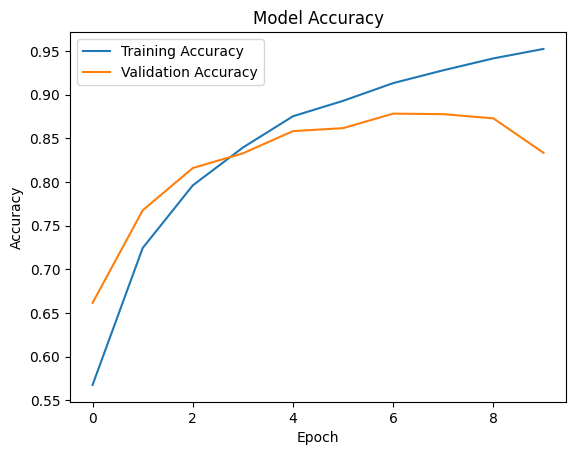

In [ ]:

# Plot the training and validation accuracy
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()


### Model 7(MobileNetV2)

In [56]:

# Define the third model using MobileNetV2 pre-trained classifier
base_model3 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
x3 = base_model3.output
x3 = Flatten()(x3)
x3 = Dense(512, activation='relu')(x3)
predictions3 = Dense(1, activation='sigmoid')(x3)
model3 = Model(inputs=base_model3.input, outputs=predictions3)

# Freeze the pre-trained layers
for layer in base_model3.layers:
    layer.trainable = False

# Compile the model
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model3.summary()


9406464/9406464 [==============================] - 1s 0us/step
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_5[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)           

In [57]:

# Train the third model
history3 = model3.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=5,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)



Epoch 1/10
625/625 [==============================] - 91s 139ms/step - loss: 0.5652 - accuracy: 0.9487 - val_loss: 0.1054 - val_accuracy: 0.9589
Epoch 2/10
625/625 [==============================] - 93s 148ms/step - loss: 0.0683 - accuracy: 0.9750 - val_loss: 0.1257 - val_accuracy: 0.9577
Epoch 3/10
625/625 [==============================] - 92s 148ms/step - loss: 0.0465 - accuracy: 0.9830 - val_loss: 0.1381 - val_accuracy: 0.9583
Epoch 4/10
625/625 [==============================] - 112s 179ms/step - loss: 0.0349 - accuracy: 0.9866 - val_loss: 0.2654 - val_accuracy: 0.9411
Epoch 5/10
625/625 [==============================] - 114s 183ms/step - loss: 0.0195 - accuracy: 0.9922 - val_loss: 0.1419 - val_accuracy: 0.9607
Epoch 6/10
625/625 [==============================] - 115s 183ms/step - loss: 0.0198 - accuracy: 0.9929 - val_loss: 0.1779 - val_accuracy: 0.9597
Epoch 7/10
625/625 [==============================] - 109s 173ms/step - loss: 0.0214 - accuracy: 0.9931 - val_loss: 0.1820 - va

In [58]:

test_loss3, test_accuracy3 = model3.evaluate(test_generator)
print('Model 3 - Test loss:', test_loss3)
print('Model 3 - Test accuracy:', test_accuracy3)


157/157 [==============================] - 18s 113ms/step - loss: 0.2103 - accuracy: 0.9648
Model 3 - Test loss: 0.21025575697422028
Model 3 - Test accuracy: 0.9647859334945679


In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Generate predictions on the test data
y_pred = model3.predict(test_generator)
y_pred = np.round(y_pred).flatten()

# Get the true labels from the test data
y_true = test_generator.classes

# Compute classification metrics
report = classification_report(y_true, y_pred, target_names=['cat', 'dog'])
print(report)


157/157 [==============================] - 48s 121ms/step
              precision    recall  f1-score   support

         cat       0.49      0.50      0.50      2499
         dog       0.49      0.49      0.49      2499

    accuracy                           0.49      4998
   macro avg       0.49      0.49      0.49      4998
weighted avg       0.49      0.49      0.49      4998



157/157 [==============================] - 25s 160ms/step


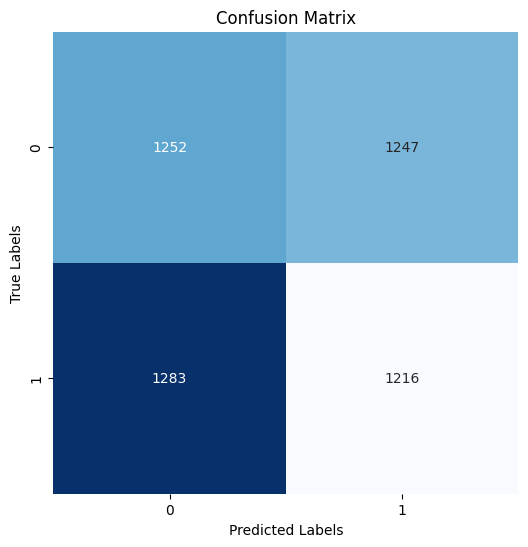

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate predictions on the test data
y_pred = model3.predict(test_generator)
y_pred = np.round(y_pred).flatten()

# Get the true labels from the test data
y_true = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


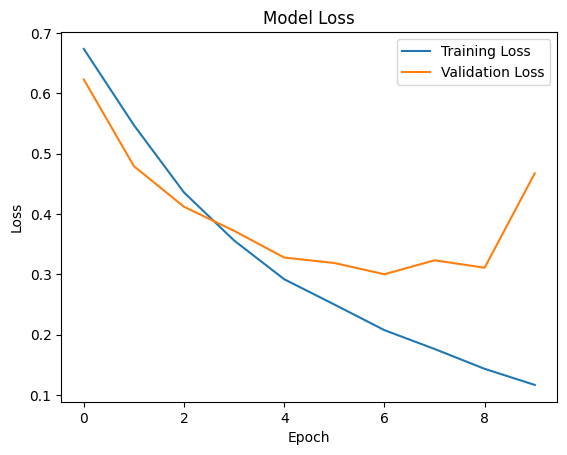

In [ ]:

# Plot the training and validation loss
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()


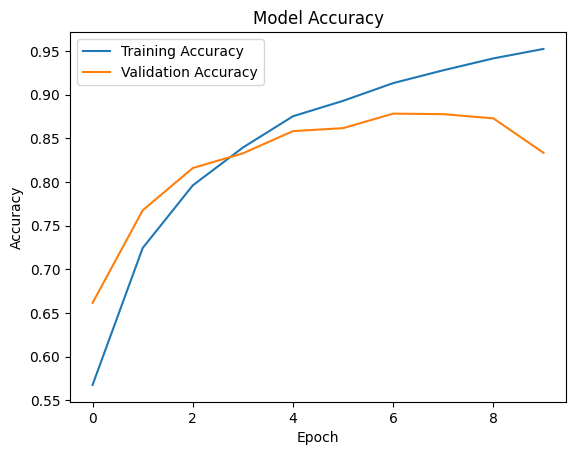

In [ ]:

# Plot the training and validation accuracy
plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()


### Model-8(InceptionV3)

In [69]:
# Define the InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


87910968/87910968 [==============================] - 5s 0us/step
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_42 (Conv2D)             (None, 74, 74, 32)   864         ['input_6[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d_42[0][0]']              
 alization)                                                                                       
                           

In [70]:

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=5,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)


Epoch 1/5
625/625 [==============================] - 112s 169ms/step - loss: 0.1140 - accuracy: 0.9554 - val_loss: 0.0974 - val_accuracy: 0.9631
Epoch 2/5
625/625 [==============================] - 127s 204ms/step - loss: 0.0731 - accuracy: 0.9723 - val_loss: 0.1040 - val_accuracy: 0.9593
Epoch 3/5
625/625 [==============================] - 141s 226ms/step - loss: 0.0589 - accuracy: 0.9785 - val_loss: 0.0990 - val_accuracy: 0.9615
Epoch 4/5
625/625 [==============================] - 144s 230ms/step - loss: 0.0453 - accuracy: 0.9829 - val_loss: 0.0990 - val_accuracy: 0.9635
Epoch 5/5
625/625 [==============================] - 103s 166ms/step - loss: 0.0344 - accuracy: 0.9875 - val_loss: 0.1139 - val_accuracy: 0.9613


In [71]:

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

157/157 [==============================] - 19s 121ms/step - loss: 0.1138 - accuracy: 0.9614
Test loss: 0.1138031855225563
Test accuracy: 0.9613845348358154


In [72]:
import numpy as np
from sklearn.metrics import classification_report

# Generate predictions on the test data
y_pred = model.predict(test_generator)
y_pred = np.round(y_pred).flatten()

# Get the true labels from the test data
y_true = test_generator.classes

# Compute classification metrics
report = classification_report(y_true, y_pred, target_names=['cat', 'dog'])
print(report)


157/157 [==============================] - 21s 124ms/step
              precision    recall  f1-score   support

         cat       0.51      0.49      0.50      2499
         dog       0.51      0.53      0.52      2499

    accuracy                           0.51      4998
   macro avg       0.51      0.51      0.51      4998
weighted avg       0.51      0.51      0.51      4998



157/157 [==============================] - 18s 114ms/step


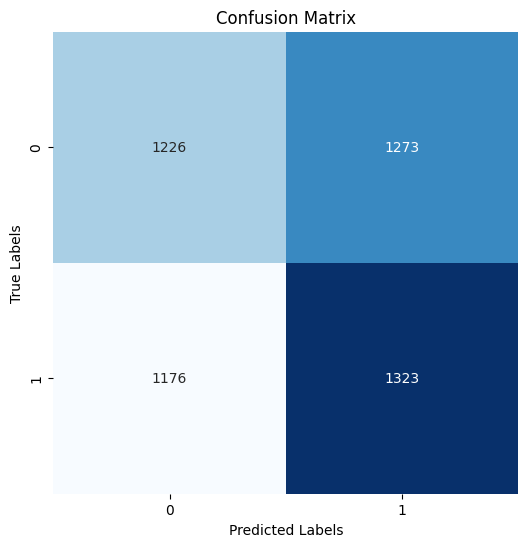

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate predictions on the test data
y_pred = model.predict(test_generator)
y_pred = np.round(y_pred).flatten()

# Get the true labels from the test data
y_true = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


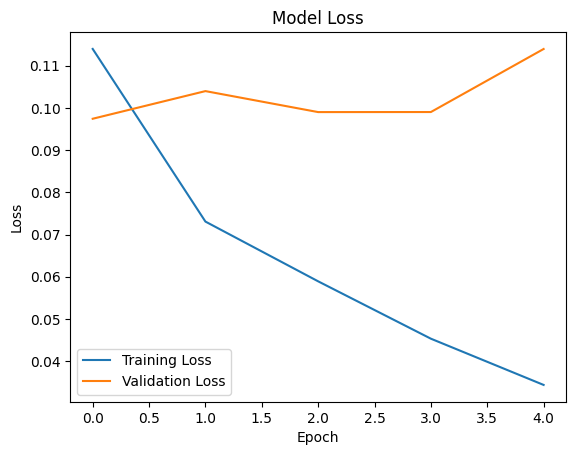

In [74]:

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()


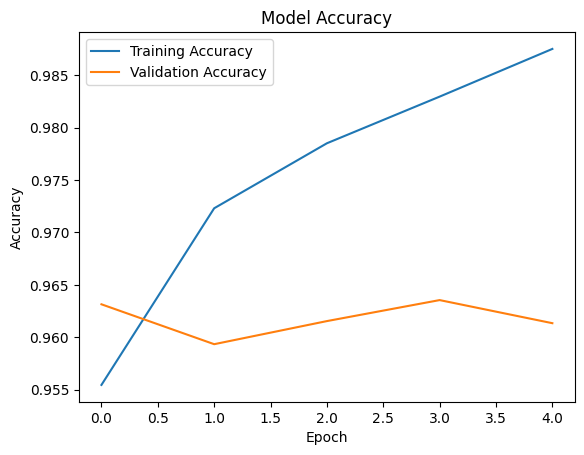

In [75]:

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()


## Model Comparison

In [18]:
pd.DataFrame({"Models":["Model-1","Model-2","Model-3","Model-4","Model-5","Model-6","Model-7","Model-8"],
              "Train Accuracy":[0.9761,0.9525,0.8408,0.6111,0.9932,0.7398,0.9952,0.9875],
              "Validation Accuracy":[0.8614,0.8335,0.8287,0.6004,0.9081,0.7017,0.9649,0.9613],
              "Test Accuracy":[0.8613,0.8335,0.8289,0.6006,0.9082,0.7015,0.9648,0.9614]})

,Models,Train Accuracy,Validation Accuracy,Test Accuracy
0,Model-1,0.9761,0.8614,0.8613
1,Model-2,0.9525,0.8335,0.8335
2,Model-3,0.8408,0.8287,0.8289
3,Model-4,0.6111,0.6004,0.6006
4,Model-5,0.9932,0.9081,0.9082
5,Model-6,0.7398,0.7017,0.7015
6,Model-7,0.9952,0.9649,0.9648
7,Model-8,0.9875,0.9613,0.9614


Observations:
- Model-1 has the highest train accuracy of 0.9761, indicating a good fit to the training data. However, its validation and test accuracies are slightly lower at 0.8614 and 0.8613, respectively.

- Model-2 has a slightly lower train accuracy of 0.9525 compared to Model-1. Its validation and test accuracies are also slightly lower at 0.8335.

- Model-3 has a train accuracy of 0.8408, which is lower than both Model-1 and Model-2. Its validation and test accuracies are also relatively low at 0.8287 and 0.8289, respectively.

- Model-4 has the lowest train accuracy of 0.6111, indicating poor fit to the training data. Its validation and test accuracies are also low at 0.6004 and 0.6006, respectively.

- Model-5 has a high train accuracy of 0.9932, indicating a good fit to the training data. Its validation and test accuracies are also high at 0.9081 and 0.9082, respectively.

- Model-6 has a train accuracy of 0.7398, which is relatively lower compared to other models. Its validation and test accuracies are also lower at 0.7017 and 0.7015, respectively.

- Model-7 has a very high train accuracy of 0.9952, indicating a strong fit to the training data. Its validation and test accuracies are also high at 0.9649 and 0.9648, respectively.

- Model-8 has a high train accuracy of 0.9875, similar to Model-7. Its validation and test accuracies are also high at 0.9613 and 0.9614, respectively.

Overall, Model-7 and Model-8 show the highest validation and test accuracies, indicating better generalization performance. Model-4 has the lowest accuracies, suggesting poor performance on both training and testing data. It's important to consider the trade-off between training accuracy and generalization when selecting the best model for deployment. So we would be looking for cross validation with model-7 to generalize the values.

<b>Using K-fold cross validation on the best model

In [20]:
# # Set the path to the dataset folder
data_dir = '/content/CatsDogs/Converted'

# # Perform train-test split
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    # color_mode='grayscale',  # Convert images to grayscale
    seed=42
)

test_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    # color_mode='grayscale',  # Convert images to grayscale
    seed=42
)

Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


In [21]:
# Model 7 seems to be the best model so we will be using K-fold cross validation over this model
from sklearn.model_selection import StratifiedKFold
# Get the image data and labels
images = train_generator[0][0]
labels = train_generator[0][1]
num_folds = 5

# Create Stratified K-fold cross-validator
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

fold_losses = []
fold_accuracies = []

# Perform K-fold cross-validation
for fold, (train_indices, val_indices) in enumerate(kfold.split(images, labels)):
    print(f"Fold: {fold+1}")
    train_images, val_images = images[train_indices], images[val_indices]
    train_labels, val_labels = labels[train_indices], labels[val_indices]

    # Define the third model using MobileNetV2 pre-trained classifier
    base_model3 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    x3 = base_model3.output
    x3 = Flatten()(x3)
    x3 = Dense(512, activation='relu')(x3)
    predictions3 = Dense(1, activation='sigmoid')(x3)
    model = Model(inputs=base_model3.input, outputs=predictions3)

    # Freeze the pre-trained layers
    for layer in base_model3.layers:
        layer.trainable = False

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    # Train the model
    history = model.fit(train_images, train_labels, batch_size=batch_size, epochs=10)

    # Evaluate the model on validation data
    val_loss, val_accuracy = model.evaluate(val_images, val_labels)
    fold_losses.append(val_loss)
    fold_accuracies.append(val_accuracy)



Fold: 1
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][0]'] 

Fold: 2
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_3[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][0]'] 

Fold: 3
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_4[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][0]'] 

Fold: 4
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_5[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][0]'] 

Fold: 5
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_6[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][0]'] 

In [22]:
# Calculate the average loss and accuracy across all folds
avg_loss = np.mean(fold_losses)
avg_accuracy = np.mean(fold_accuracies)

print('Average Validation Loss:', avg_loss)
print('Average Validation Accuracy:', avg_accuracy)

Average Validation Loss: 0.45122091194098174
Average Validation Accuracy: 0.938095235824585


- So now from the cross validation, we can even ensure that this mobilenet model has been performing the best and is reproducible and one other good advantage of using mobilenet model is its fewer number of training parameters as compared to other models.